# Instance segmentation with Mask R-CNN

1. Semantic -> Each pixel is classified to a class
2. Semantic + object detection -> instance segmentation!


Input: batches[C, H, W]
Output: N, number of classes
- Boxes (Tensor [N,4]) -> [X0, Y0, X1, Y1]
- Labels (Tensor [N]) -> predicted labels for each image
- Scores (Tensor[N]) -> The scores of each prediction
- Masks (Tensor[N, H, W]) -> The predicted mask for each instance in 0 - 1 range.

## Imports

In [12]:
import torch
import torchvision
from torchvision import models, transforms

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import subprocess
import os
import random


In [3]:
model = models.detection.maskrcnn_resnet50_fpn(weights = torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to C:\Users\jsrinivasan/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:28<00:00, 6.34MB/s] 


In [5]:
random.seed(43)

In [6]:
def random_color_masks(image, colors):
    # image = binary mask, where detected object pixels are 1
    r, g, b = np.zeros_like(image, dtype = np.uint8), np.zeros_like(image, dtype = np.uint8), np.zeros_like(image, dtype = np.uint8)
    r[image == 1], g[image ==1], b[image ==1 ] = colors[random.randint(0, len(colors)-1)]
    return np.stack([r,g,b], axis = 2)

In [36]:
def get_prediction(img_path, threshold):
    image = Image.open(img_path)
    img_tensor = transforms.ToTensor()(image) # internally in the model it resizes, the input to the shorter dimension to 800 pixels and longer based on aspect ratio
    with torch.no_grad():
        pred = model([img_tensor])
    
    pred_data = pred[0]
    scores = pred_data['scores'].detach().cpu().numpy() 
    labels = pred_data['labels'].detach().cpu().numpy()
    boxes = pred_data['boxes'].detach().cpu().numpy()
    masks = (pred_data['masks']>0.5).squeeze().detach().cpu().numpy()

    valid_indices = scores > threshold
    if not np.any(valid_indices):
        return [], [], []
    
    pred_boxes =  [[(b[0],b[1]),(b[2],b[3])] for b in boxes[valid_indices]]
    pred_classes = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in labels[valid_indices]]
    masks = masks[valid_indices]

    return masks, pred_boxes, pred_classes



def instance_segmentation(img_path, threshold):
    masks, boxes, classes = get_prediction(img_path, threshold)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    rect_th = max(round(sum(img.shape)/2*0.003),2)
    text_th = max(rect_th-1, 1)

    for i in range(len(masks)):
        p1, p2 = (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1]))

        rgb_mask = random_color_masks(masks[i], COLORS)

        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)

        color = COLORS[COCO_INSTANCE_CATEGORY_NAMES.index(classes[i])]
        cv2.rectangle(img, p1, p2, color, rect_th)


        w, h = cv2.getTextSize(classes[i], 0, fontScale= rect_th/3, thickness= text_th)[0]
        outside = p1[1] -h >=3 
        p2 = (p1[0] + w, p1[1]-h-3) if outside else (p1[0] + w, p1[1] + h + 3)

        cv2.rectangle(img, p1, p2, color, thickness = -1)

        cv2.putText(img, classes[i], 
                    (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                    cv2.FONT_HERSHEY_SIMPLEX, rect_th/3, (255, 255, 255), thickness=text_th)

    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.show()



## Inference:

In [37]:
import requests
import certifi
# download test images
def download_file(url, save_name):
    if not os.path.exists(save_name):
        response = requests.get(url, verify= False)
        with open(save_name, 'wb') as f:
            f.write(response.content)

inference_dir = "inference_mask_rcnn"
os.makedirs(inference_dir, exist_ok = True)

(853, 1280, 3)


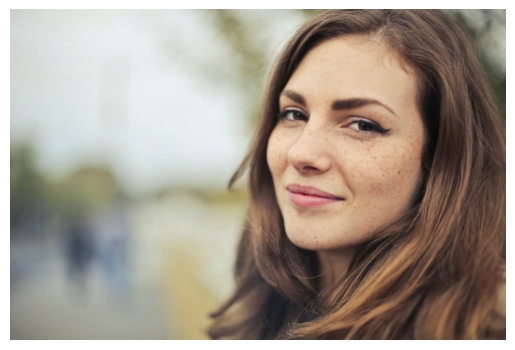

In [38]:
# Download the image and plotting it
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/person-1.jpg',
    os.path.join(inference_dir, 'person.jpg')
)

img = Image.open(os.path.join(inference_dir, 'person.jpg'))
print(np.shape(img))
plt.imshow(img)
plt.axis('off')
plt.show()

In [39]:
img_t = transforms.ToTensor()(img)
with torch.no_grad():
    pred = model([img_t])

In [40]:
pred[0]

{'boxes': tensor([[ 431.6028,    2.4547, 1280.0001,  851.2910],
         [ 119.3286,   43.6909,  862.8624,  853.0000]]),
 'labels': tensor([1, 1]),
 'scores': tensor([0.9998, 0.1074]),
 'masks': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0013, 0.0013, 0.0012],
           [0.0000, 0.0000, 0.0000,  ..., 0.0014, 0.0014, 0.0013],
           [0.0000, 0.0000, 0.0000,  ..., 0.0015, 0.0015, 0.0014],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.1385, 0.1310, 0.1234],
           [0.0000, 0.0000, 0.0000,  ..., 0.1301, 0.1230, 0.1159],
           [0.0000, 0.0000, 0.0000,  ..., 0.1216, 0.1150, 0.1083]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0

In [41]:
masks = (pred[0]['masks']>= 0.5).squeeze().detach().cpu().numpy()
masks.shape


(2, 853, 1280)

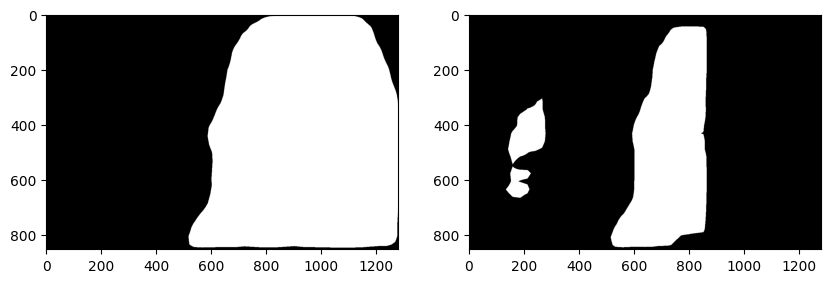

In [42]:
fig=plt.subplots(1, 2, figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(masks[0], cmap = 'gray')

plt.subplot(1, 2, 2)
plt.imshow(masks[1], cmap = 'gray')
plt.show()

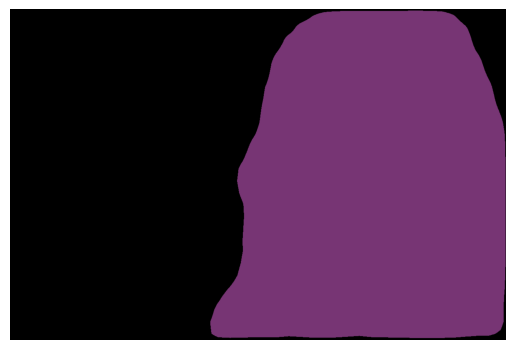

In [43]:
mask1 = random_color_masks(masks[0], COLORS)
plt.imshow(mask1)
plt.axis('off')
plt.show()

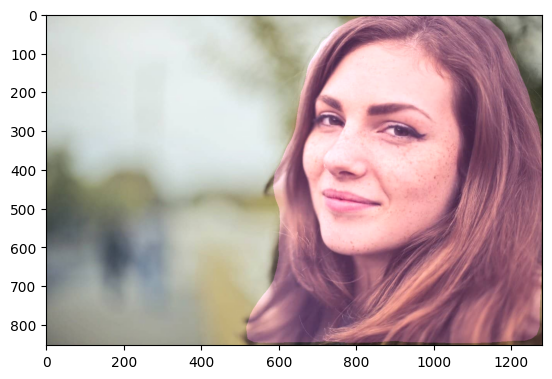

In [44]:
blend_img = cv2.addWeighted(np.array(img), 1, mask1, 0.5, 0)
plt.imshow(blend_img)

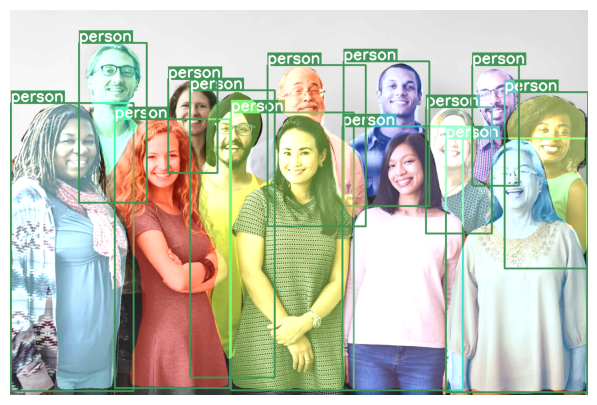

In [45]:
instance_segmentation(os.path.join(inference_dir, 'people.jpg'), 0.5)

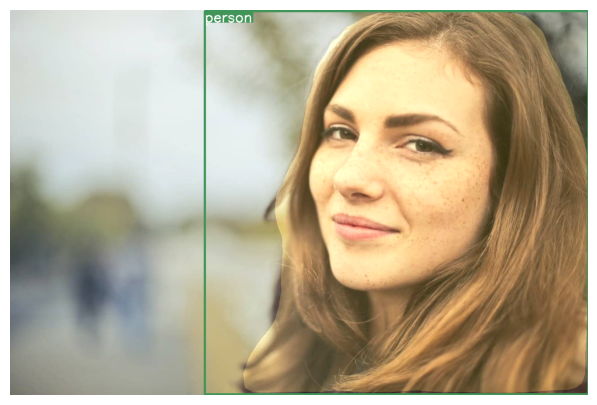

In [46]:
instance_segmentation(os.path.join(inference_dir, 'person.jpg'), 0.5)